# E. coli Promoter Classification Naive Model

In this notebook we train a classification model using only the promoter dataset - no language model pretraining. This serves as a baseline to verify the effect of unsupervised pretraining.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/e_coli/')

In [5]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [6]:
classification_df.head()

,Gene,Locus,Location,Sample Location,Orientation,Sequence,Promoter,Independent,set
0,['mokC'],['b0018'],[16750:16960](-),[16910:17060](-),reverse,TAGCGGCGGGTGCTTGAGGCTGTCTGTCTCAGGCATTAGCTGAACG...,1,False,train
1,['insB-1'],['b0021'],[19810:20314](-),[20264:20414](-),reverse,GCTCTCACTGCCGTAAAACATGGCAACTGCAGTTCACTTACACCGC...,1,False,train
2,['insA-1'],['b0022'],[20232:20508](-),[20458:20608](-),reverse,GACTCCCCCACAAAGAATATGGATATTGTGATACACATTGAGGTAG...,1,False,train
3,['rpsT'],['b0023'],[20814:21078](-),[21028:21178](-),reverse,ACGGCGCTTATTTGCACAAATCCATTGACAAAAGAAGGCTAAAAGG...,1,False,train
4,['fkpB'],['b0028'],[25825:26275](+),[25725:25875](+),forward,ACGCATCTTATCCGGCCTACAGATTGCTGCGAAATCGTAGGCCGGA...,1,False,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((6791, 9), (750, 9), (830, 9))

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, test_df=test_df, tokenizer=tok, 
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

# Data Processing

The genomic sequences for the promoters are split into 5-mers with a stride of 2. These tokens are numericalized and fed to the model. After processing all tokens in a promoter sequence, the model makes a classification prediction.

For more detail on preprocessing, see the `GenomicTokenizer` class in the `utils.py` file.

In [11]:
data_clas.train_ds[0]

(Text TAGCG GCGGC GGCGG CGGGT GGTGC TGCTT CTTGA TGAGG AGGCT GCTGT TGTCT TCTGT TGTCT TCTCA TCAGG AGGCA GCATT ATTAG TAGCT GCTGA TGAAC AACGG CGGCA GCAGA AGATA ATAGA AGAGA AGAAA AAAAG AAGCC GCCCC CCCGA CGAGT AGTGA TGATA ATATT ATTTT TTTAC TACCA CCATC ATCAA CAACC ACCCG CCGAG GAGGC GGCCT CCTCC TCCTA CTATA ATATG ATGCT GCTGA TGAAC AACAC CACAT CATGT TGTAG TAGAG GAGTG GTGCC GCCTC CTCTT CTTAC TACTG CTGAC GACCG CCGTA GTAAG AAGGT GGTCA TCAAG AAGGA GGAGA,
 Category 1)

In [14]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.2

In [15]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

The model used is based on the [AWD-LSTM](https://arxiv.org/abs/1708.02182) model. The input sequence is fed through three LSTM layers followed by several linear layers.

In [16]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.08000000000000002)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


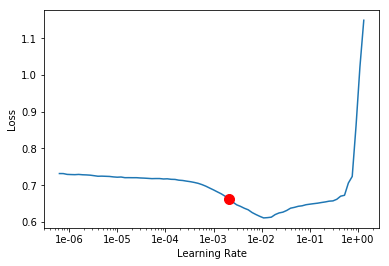

In [16]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.592741,0.692581,0.500000
2,0.464481,0.640619,0.542667
3,0.402478,0.352550,0.853333
4,0.348807,0.313955,0.864000
5,0.295296,0.294537,0.866667


In [19]:
learn.fit_one_cycle(5, 5e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.197571,0.316365,0.865333
2,0.215816,0.340545,0.860000
3,0.206282,0.379665,0.845333
4,0.185619,0.353171,0.853333
5,0.161763,0.342562,0.864000


In [20]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.123969,0.342915,0.866667
2,0.122340,0.403346,0.845333
3,0.117600,0.386390,0.853333
4,0.111036,0.370066,0.868000
5,0.103370,0.376861,0.860000


In [21]:
learn.save('coli_naive')

# Test

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, 
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.8349397590361446
False Positives: 0.07349397590361446
False Negatives: 0.09156626506024096
Recall: 0.8168674698795181
Precision: 0.8475
MCC: 0.6703175228168727


The model achieves good accuracy, precision, and recall, but can be extremely unstable. Observe how the accuracy can fluctuate sharply between epochs. Several runs were needed to get the results above. Bad initializations result in the model never actually training. In the next notebook, we will see how pretraining can significantly stabilize the model.